# CATRA experiments and analysis

### Common imports

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.set(font_scale=1.5)
sns.set_palette("Set2")

import experiments
from experiments import Status

In [2]:
#! cat results/catra-0.1.4-5.experiments.batch_{0..7}.log results/catra-0.1.4-5.experiments.batch_missing.log > master-results.log

### Constants

In [3]:
commit = "5810e6d"
#logfile = f"master-results.log"
TIMEOUT_S = 30 # FIXME read from log

##  Instances solved
How many instances can we solve, in general?

In [7]:
runtimes = experiments.log2df("nuxmv-lazy-0.1.5-8.experiments.log")

An issue with the experiment setup led us to re-run some benchmarks using the default catra front-end: they are included here:

In [20]:
#extra_runtimes = pd.concat([experiments.parse_catra_log(
#    f"results/catra-0.1.4-5.experiments.batch_missing2_{backend}.log", name)
#                  for backend, name in [("baseline", "baseline"), ("lazy", "PC*"), ("nuxmv", "nuXmv")]])

...and dropped by deduplication here:

In [9]:
#runtimes = pd.concat([runtimes, extra_runtimes]).drop_duplicates(subset=["instance", "backend"],
#                                                                 keep="last")
runtimes.backend = runtimes.backend.str.replace("nuxmv", "nuXmv")
runtimes.backend = runtimes.backend.str.replace("lazy", "PC*")

In [10]:
best_status = runtimes.groupby('instance').status.min()

How many instances for the respective backends?

In [11]:
runtimes.groupby(['backend']).size()

backend
PC*      37497
nuXmv    37497
dtype: int64

In [12]:
NR_INSTANCES = runtimes.instance.unique().size
NR_INSTANCES

37497

In [13]:
timeout_instances = best_status[best_status == Status.TIMEOUT].reset_index().instance
#runtimes = runtimes[~runtimes['instance'].isin(timeout_instances)]

How many instances had all solvers time out?

In [14]:
timeout_instances.size

11602

In [15]:
#results_per_instance = runtimes.groupby('instance').size()
#tried_on_all = results_per_instance[results_per_instance == runtimes.backend.cat.categories.size ].reset_index().instance
# runtimes = runtimes[runtimes['instance'].isin(tried_on_all)]

## Correctness check

In [16]:
success_runs = runtimes[runtimes['status'] < Status.TIMEOUT]
success_runs_by_instance = success_runs.groupby(['instance'])

nr_statuses = success_runs_by_instance.status.nunique().reset_index()
nr_statuses[nr_statuses['status'] != 1]

,instance,status


It's empty so they all concur!

In [17]:
success_runs.groupby(['instance', 'status'], observed=False).size()

instance                        status           
../deduped-benchmarks/0.par     Status.SAT           1
                                Status.UNSAT         0
                                Status.TIMEOUT       0
                                Status.MEMORY_OUT    0
                                Status.ERROR         0
                                                    ..
../deduped-benchmarks/9997.par  Status.SAT           2
                                Status.UNSAT         0
                                Status.TIMEOUT       0
                                Status.MEMORY_OUT    0
                                Status.ERROR         0
Length: 129475, dtype: int64

### Errors

In [18]:
runtimes[runtimes['status'] > Status.TIMEOUT]

,backend,instance,status,runtime
34,PC*,../deduped-benchmarks/31554.par,Status.ERROR,inf
134,PC*,../deduped-benchmarks/25535.par,Status.ERROR,inf
660,PC*,../deduped-benchmarks/25737.par,Status.ERROR,inf
664,PC*,../deduped-benchmarks/23346.par,Status.ERROR,inf
1444,PC*,../deduped-benchmarks/24207.par,Status.ERROR,inf
...,...,...,...,...
73746,PC*,../deduped-benchmarks/32332.par,Status.MEMORY_OUT,inf
74216,PC*,../deduped-benchmarks/23377.par,Status.ERROR,inf
74482,PC*,../deduped-benchmarks/13707.par,Status.ERROR,inf
74792,PC*,../deduped-benchmarks/21004.par,Status.ERROR,inf


## Outcomes

How many instances are in each category, per backend?

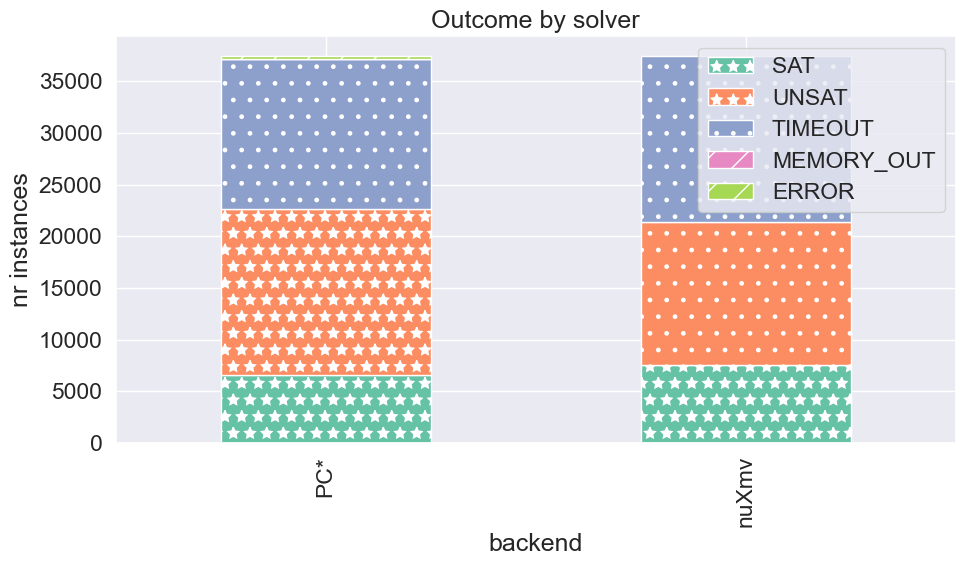

In [21]:
fig, ax = plt.subplots()
runtime_by_status = runtimes.groupby(['backend', 'status'], observed=False).size().reset_index()
runtime_by_status = runtime_by_status[runtime_by_status[0] > 0]
runtime_by_status.rename(columns = {0: 'count'}, inplace = True)
runtime_by_status = runtime_by_status.set_index(['backend', 'status'])
plot = runtime_by_status.unstack().plot.bar(figsize=(10,6), 
                                     stacked=True, 
                                     ylabel="nr instances",
                                     title="Outcome by solver", 
                                     ax=ax)


nr_solvers = 3
bars = plot.patches
hatches = [ *(["*"] * nr_solvers), *(["."] * nr_solvers), *(["/"] * nr_solvers), *(["x"] * nr_solvers)]


for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)

ax.legend([str(heading).replace("Status.", "") for _, heading in runtime_by_status.unstack().columns])


plt.tight_layout()
plt.savefig(f'{commit}-by-solver.pdf', dpi=300)

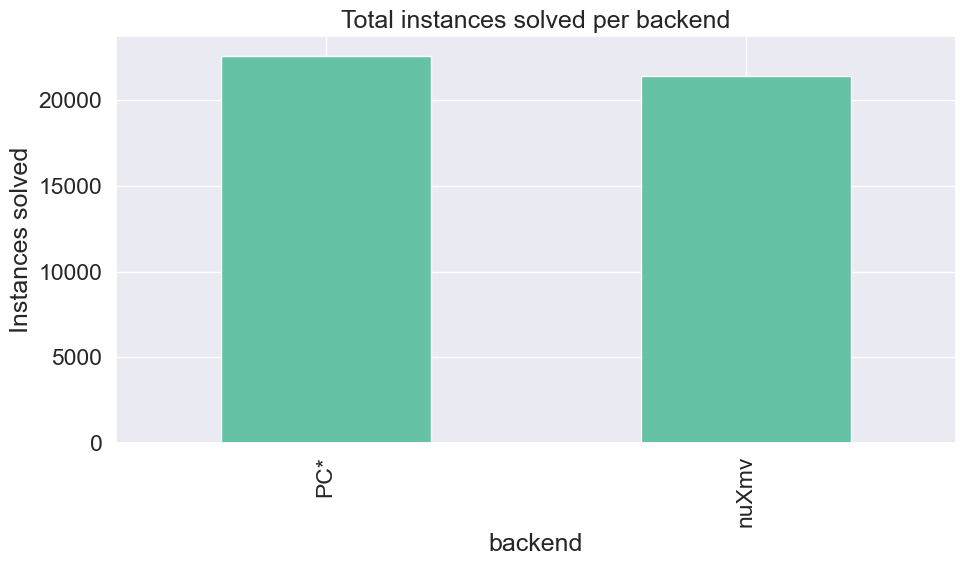

In [22]:
nr_solved = runtimes.groupby(['backend', 'status'], observed=False).size().reset_index()
nr_solved = nr_solved.loc[nr_solved.status.apply(lambda s: s in [Status.SAT, Status.UNSAT])]
nr_solved.groupby('backend').sum(numeric_only=True).plot.bar(legend=False,
                                            figsize=(10,6),
                                            ylabel="Instances solved",
                                            title="Total instances solved per backend")
plt.tight_layout()

How do the respective solvers do on each type of instance?

In [34]:
by_sat_status = pd.DataFrame(runtimes.groupby('instance').status.min())
by_sat_status['kind'] = by_sat_status['status'].astype("category")
by_sat_status['kind'] = by_sat_status.kind.cat.set_categories([Status.SAT, Status.UNSAT])
del(by_sat_status['status'])

known_solved_with_kind = runtimes[runtimes['status'] < Status.TIMEOUT]\
    .join(by_sat_status, on='instance')

In [35]:
tbl = pd.pivot_table(known_solved_with_kind, values=['runtime'], 
               index=['kind'], columns=['backend'],
               observed=False,
               aggfunc='count')['runtime']
tbl.style.to_latex("solved_pivot_table.tex", hrules=True)
tbl

backend,PC*,nuXmv
kind,,
Status.SAT,6587,7532
Status.UNSAT,16022,13903


## Execution time
For solved instances, for each backend plot the distribution of runtimes

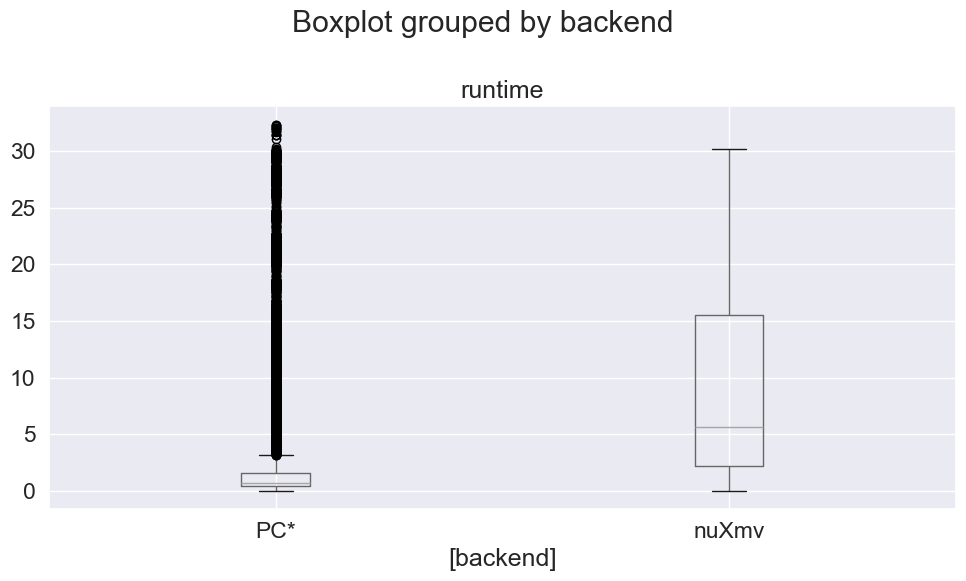

In [36]:
runtimes[runtimes['status'] < Status.TIMEOUT].boxplot(by='backend', figsize=(10,6))
plt.tight_layout()
plt.savefig(f'{commit}-time-boxplot.pdf', dpi=300)

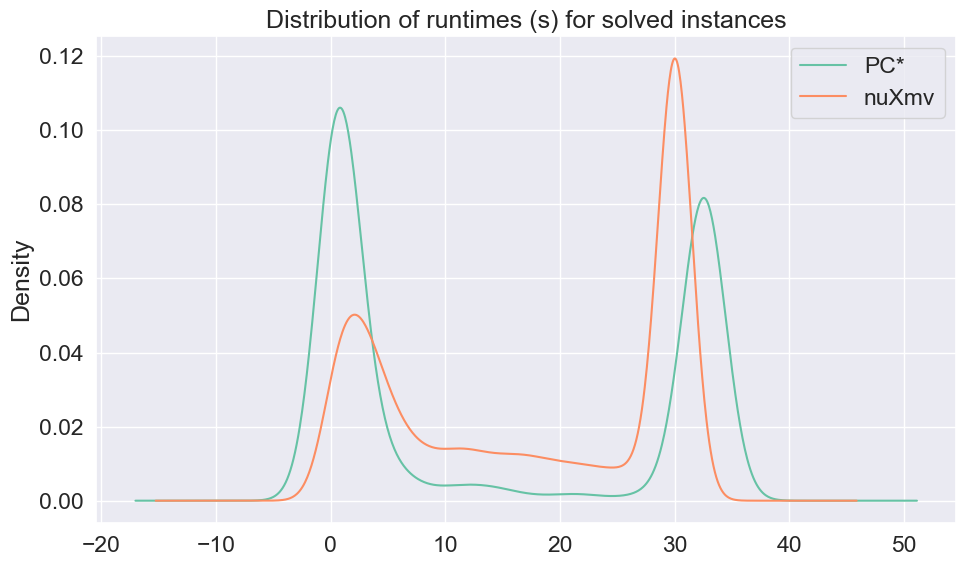

In [37]:
runtimes[runtimes['runtime'] < float('inf')]\
    .set_index('instance')\
    .groupby('backend')\
    .runtime\
    .plot.kde(xlabel='Runtime (s)',
              legend=True,
              figsize=(10, 6),
              title='Distribution of runtimes (s) for solved instances')
plt.tight_layout()

## Scalability (this is the cactus plot section)
If we add more time, how many more instances can we solve?

Which ones are we missing?

In [78]:
baseline_missing = set(experiments.log2df("catra-nuxmv.120s.log").instance) \
    - set(experiments.log2df("baseline-catra-2.120000.log").instance)

In [80]:
len(baseline_missing)

264

(These were manually re-executed as the single job on one JVM)

In [45]:
lazy_special_missing = set(experiments.log2df("catra-nuxmv.120s.log").instance) \
    - set(experiments.log2df("lazy-no-clauselearning,lazy-no-clauselearning-no-restarts,lazy-eager-200,lazy-lazy-1-catra-12.120000.log").instance)

In [47]:
lazy_special_missing

set()

Nice, none!

In [9]:
cactus_runtimes = pd.concat([
    experiments.log2df("lazy-no-clauselearning,lazy-no-clauselearning-no-restarts,lazy-eager-200,lazy-lazy-1-catra-12.120000.log"),
    experiments.log2df("baseline-catra-2.120000.log"),
    experiments.log2df("catra-nuxmv.120s.log"),
    experiments.log2df("baseline-catra-1.120000.log")#, # Makeup experiments for baseline
    #experiments.parse_catra_log("catra-120-rerun/filelist_catra1", "baseline-philipp"),
    #experiments.parse_catra_log("catra-120-rerun/filelist_catra2", "PC*-philipp"),
    #experiments.parse_catra_log("catra-120-rerun/filelist_catra3", "PC* no restarts, no clause learning Philipp"),
    #experiments.parse_catra_log("catra-120-rerun/filelist_catra4", "PC* eager, Philipp"),
    #experiments.parse_catra_log("catra-120-rerun/filelist_catra5", "PC* lazy, Philipp")
])

#cactus_runtimes.backend = cactus_runtimes.backend.str.replace("lazy", "PC*")

cactus_runtimes.backend = cactus_runtimes.backend.str.replace("nuxmv-cactus", "nuXmv")
cactus_runtimes.backend = cactus_runtimes.backend.str.replace("lazy-lazy-1", "PC*, product threshold = 1")
cactus_runtimes.backend = cactus_runtimes.backend.str.replace("lazy-eager-200", "PC*, product threshold = 200")
cactus_runtimes.backend = cactus_runtimes.backend.str.replace("lazy-no-clauselearning-no-restarts", "PC*, no clause learning, no restarts")
cactus_runtimes.backend = cactus_runtimes.backend.str.replace("lazy-no-clauselearning", "PC*, no clause learning")
cactus_runtimes.backend = cactus_runtimes.backend.str.replace("lazy-cactus", "PC*")


# This is because apparently Pandas loses the categoricity when concatenating, and apparently 
# that breaks plotting with the least useful error messages you can imagine. Pandas is bad.
cactus_runtimes['backend'] = cactus_runtimes['backend'].astype("category") 

In [10]:
nr_total, cactus_data = experiments.prepare_cactus_plot(cactus_runtimes, timeout_s=120, step_size=1.5)

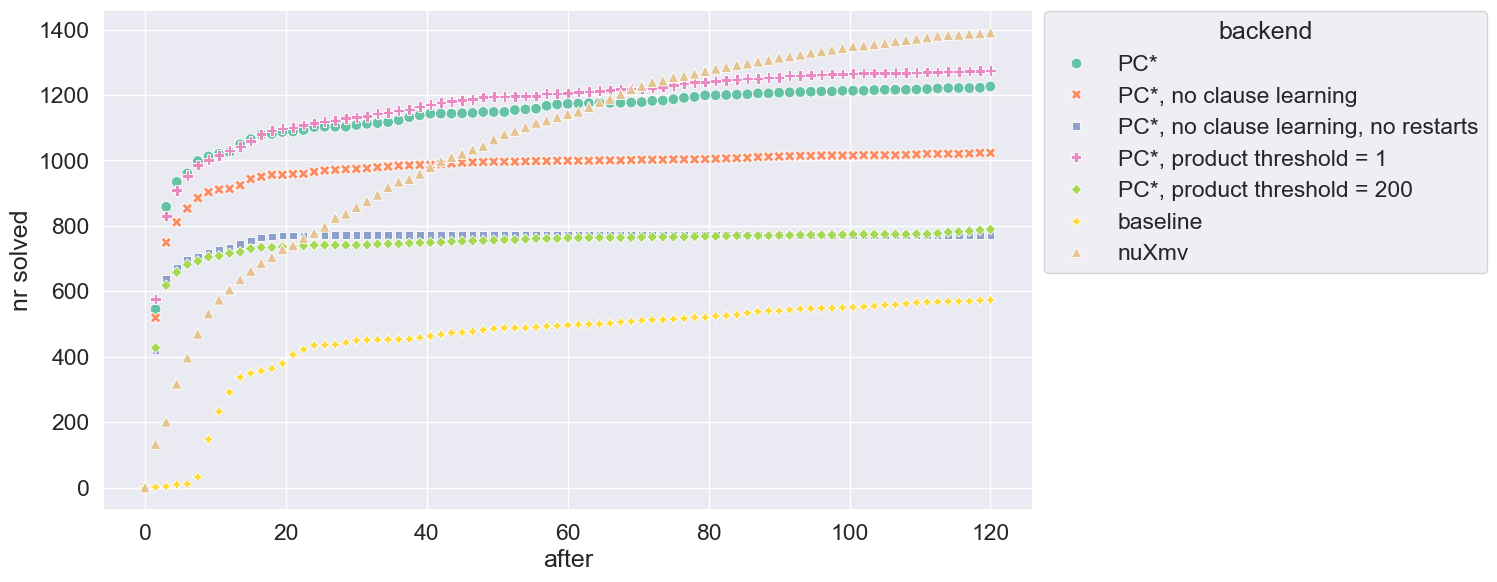

In [11]:
fig, ax = plt.subplots(figsize=(12,6.5))

p = sns.scatterplot(data=cactus_data, 
                    x='after', 
                    y='nr solved', 
                    hue='backend', 
                    style='backend',
                    s=60,
                    ax=ax)

#ax.set_ylim(0, nr_total)

sns.move_legend(p, bbox_to_anchor=(1, 1.02), loc='upper left')
plt.savefig(f'{commit}-cactus.pdf', dpi=300)

## Duels
This is where we compare pairs of backends. In order to make timeouts plottable we set the runtime of an instance that timed out to the timeout value, as opposed to positive infinity.

In [49]:
runtimes_by_backend = runtimes[runtimes['status'] < Status.TIMEOUT].set_index(['instance', 'backend']).runtime\
    .unstack()\
    .replace(to_replace=float('inf'), value=TIMEOUT_S)

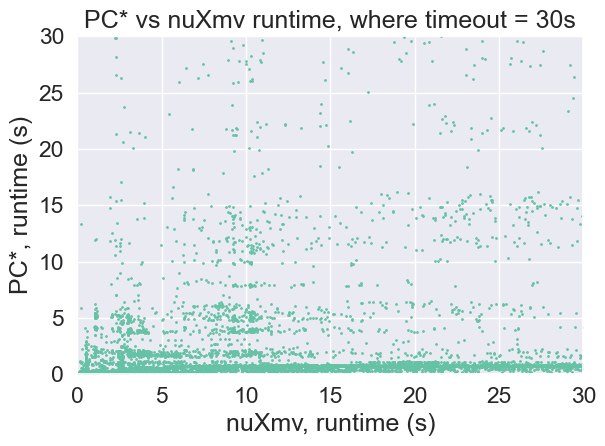

In [52]:
ax = runtimes_by_backend.plot.scatter(x='nuXmv', y='PC*', 
                                 title=f"PC* vs nuXmv runtime, where timeout = {TIMEOUT_S}s", 
                                 s=1,
                                 ylabel="PC*, runtime (s)",
                                 xlabel="nuXmv, runtime (s)")
ax.set_xlim(0, 30)
ax.set_ylim(0, 30)


plt.tight_layout()
plt.savefig(f'{commit}-duels-lazy-nuxmv-scatter.pdf', dpi=300)

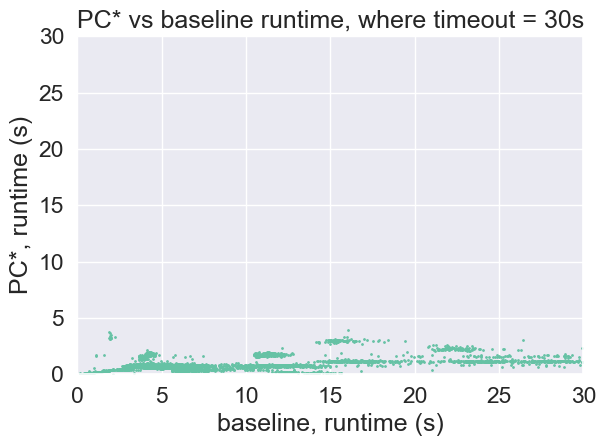

In [54]:
ax = runtimes_by_backend.plot.scatter(x='baseline', 
                                      y='PC*',
                                      ylabel="PC*, runtime (s)",
                                      xlabel="baseline, runtime (s)",
                                      title=f"PC* vs baseline runtime, where timeout = {TIMEOUT_S}s",
                                      s=1)
ax.set_xlim(0, 30)
ax.set_ylim(0, 30)

plt.tight_layout()
plt.savefig(f'{commit}-duels-lazy-baseline-scatter.pdf', dpi=300)

In [55]:
runtimes

,backend,instance,status,runtime
0,baseline,../../../anonymous/deduped-benchmarks/11292.par,Status.TIMEOUT,30.009497
1,PC*,../../../anonymous/deduped-benchmarks/11292.par,Status.TIMEOUT,32.579076
2,nuXmv,../../../anonymous/deduped-benchmarks/11292.par,Status.TIMEOUT,30.021835
3,baseline,../../../anonymous/deduped-benchmarks/10796.par,Status.UNSAT,7.639953
4,PC*,../../../anonymous/deduped-benchmarks/10796.par,Status.UNSAT,0.339794
...,...,...,...,...
2795,nuXmv,../../../anonymous/deduped-benchmarks/36690.par,Status.TIMEOUT,inf
2796,nuXmv,../../../anonymous/deduped-benchmarks/28476.par,Status.TIMEOUT,inf
2797,nuXmv,../../../anonymous/deduped-benchmarks/37161.par,Status.TIMEOUT,inf
2798,nuXmv,../../../anonymous/deduped-benchmarks/29908.par,Status.TIMEOUT,inf
